<a href="https://colab.research.google.com/github/kimdesok/Introduction-to-TensorFlow-for-Artificial-Intelligence-Machine-Learning-and-Deep-Learning-Coursera/blob/master/C2/C2_W3_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer the learned layers and train the top layers
> 1) just get the convolution layers of one model <br>
> 2) attach some dense layers onto it <br>
> 3) train just the dense network <br>
> 4) evaluate the results <br>
> 5) fine tune by unfreeze a part or whole layers <br>
> 6) re-evaluate

###Setup the pretrained model

In [1]:
#Download the pre-trained weights.  No top means no fully connected dense layer.
!wget --no-check-certificate \
https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
-O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-06-06 18:59:06--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  83.7MB/s    in 1.0s    

2022-06-06 18:59:08 (83.7 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape =(150,150,3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

#Freeze the weights of the layers
for layer in pre_trained_model.layers:
  layer.trainable = False


In [3]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [4]:
last_layer = pre_trained_model.get_layer('mixed7') # choose this layer as the last layer
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


### Add dense layers for the classifier

In [5]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

#Append the dense network to the base model
model = Model (pre_trained_model.input, x)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [7]:
#set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.001), loss = 'binary_crossentropy', metrics=['accuracy'])

###Prepare the dataset

In [8]:
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2022-06-06 18:59:19--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  37.3MB/s    in 1.8s    

2022-06-06 18:59:21 (37.3 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [26]:
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

#Zip file handling
def zip_extract(filename, extract_dir):
  zip_ref = zipfile.ZipFile(filename, 'r')
  zip_ref.extractall(extract_dir)
  zip_ref.close()

#Data generator handling
def gen_dataset(base_dir, dataset_type, labels):
  data_dir = os.path.join( base_dir, dataset_type)
  data_label_dir = [os.path.join(data_dir, label) for label in labels]

  if(dataset_type == 'test'):
    data_datagen = ImageDataGenerator(rescale=1.0/255.)
    return data_datagen

  else:
    data_datagen = ImageDataGenerator(rescale=1./255., 
                                    rotation_range=40,
                                    width_shift_range = 0.2,
                                    height_shift_range =0.2,
                                    shear_range =0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)
    
    data_generator = data_datagen.flow_from_directory(data_dir, 
                                                      batch_size=20, 
                                                      class_mode='binary',
                                                      target_size=(150,150))
    return data_generator, data_label_dir

#Plot handling
def plot_results(history, eval_type):
    train_graph = history.history[eval_type]
    validation_graph = history.history['val_'+eval_type]

    epochs = range(len(train_graph))

    plt.plot(epochs, train_graph, 'green', label = 'Training ' + eval_type )
    plt.plot(epochs, validation_graph, 'orange', label = 'Validation ' +eval_type)
    plt.title('Training and Validation ' + eval_type)
    plt.legend(loc=0)
    plt.grid(color='lightgray', alpha = 0.8)

    plt.show()





##Prepare the dataset

In [27]:
zip_extract('cats_and_dogs_filtered.zip', 'tmp')

labels = ['cats', 'dogs']

train_generator, train_label_dir = gen_dataset('tmp/cats_and_dogs_filtered', 'train', labels)

validation_generator, validation_label_dir = gen_dataset('tmp/cats_and_dogs_filtered', 'validation', labels)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Train the model

In [13]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 37s - loss: 1.4139 - accuracy: 0.8180 - val_loss: 0.9811 - val_accuracy: 0.8260 - 37s/epoch - 369ms/step
Epoch 2/20
100/100 - 22s - loss: 0.4011 - accuracy: 0.8910 - val_loss: 0.2786 - val_accuracy: 0.9150 - 22s/epoch - 220ms/step
Epoch 3/20
100/100 - 22s - loss: 0.3622 - accuracy: 0.9105 - val_loss: 0.3067 - val_accuracy: 0.9090 - 22s/epoch - 218ms/step
Epoch 4/20
100/100 - 22s - loss: 0.2996 - accuracy: 0.9200 - val_loss: 0.2774 - val_accuracy: 0.9240 - 22s/epoch - 219ms/step
Epoch 5/20
100/100 - 22s - loss: 0.3192 - accuracy: 0.9150 - val_loss: 0.3555 - val_accuracy: 0.9010 - 22s/epoch - 218ms/step
Epoch 6/20
100/100 - 23s - loss: 0.2747 - accuracy: 0.9215 - val_loss: 0.1781 - val_accuracy: 0.9410 - 23s/epoch - 225ms/step
Epoch 7/20
100/100 - 22s - loss: 0.2491 - accuracy: 0.9305 - val_loss: 0.2219 - val_accuracy: 0.9310 - 22s/epoch - 218ms/step
Epoch 8/20
100/100 - 22s - loss: 0.2488 - accuracy: 0.9275 - val_loss: 0.2872 - val_accuracy: 0.9260 - 22s/epoch - 219

##Evaluate the results

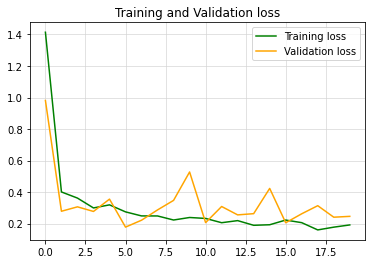

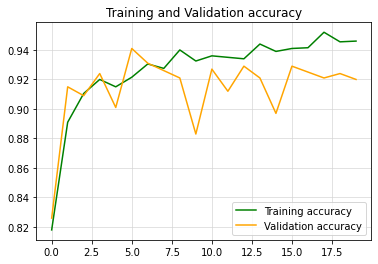

In [24]:
plot_results(history, 'loss')
plot_results(history, 'accuracy')


